# Success/Errors Histogram

In [1]:
import torch
import torch.nn.functional as F
import numpy as np
from tqdm.notebook import tqdm
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.insert(0, '../')
from loaders import get_loader
from learners import get_learner
from utils import misc

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# DEFINE HERE YOUR CONFIG PATH AND THE EPOCH YOU WANT TO EVALUATE
config_path = '/data/DEEPLEARNING/ccorbiere/logs/cifar10/github_weights/baseline/config_1.yaml' 
ckpt_path = '/data/DEEPLEARNING/ccorbiere/logs/cifar10/github_weights/baseline/model_epoch_197.ckpt'
config_args = misc.load_yaml(config_path)

In [3]:
# Get data loader
dloader = get_loader(config_args)
dloader.make_loaders()

2019-12-22 21:20:40,127 gpuserver3 confidnet.loaders.loader[17796] INFO --- Augmentations ---
2019-12-22 21:20:40,129 gpuserver3 confidnet.augmentations[17796] INFO Using hflip aug with params True
2019-12-22 21:20:40,130 gpuserver3 confidnet.augmentations[17796] INFO Using rotate aug with params 15
2019-12-22 21:20:40,131 gpuserver3 confidnet.augmentations[17796] INFO Using No Augmentations


Files already downloaded and verified
Files already downloaded and verified


2019-12-22 21:20:42,056 gpuserver3 confidnet.loaders.loader[17796] WARNING Loading existing train-val split indices


In [4]:
# Initialize and load model
learner = get_learner(config_args, dloader.train_loader, dloader.val_loader, dloader.test_loader, -1, device)
checkpoint = torch.load(ckpt_path)
learner.model.load_state_dict(checkpoint["model_state_dict"])

2019-12-22 21:20:51,473 gpuserver3 confidnet.learners.learner[17796] INFO Using optimizer adam
2019-12-22 21:20:51,475 gpuserver3 confidnet.learners.learner[17796] INFO Using loss cross_entropy


<All keys matched successfully>

In [5]:
def predict_test_set(learner, mode='normal', samples=50, verbose=True):
    accurate, errors, confidence = [], [], []
    loop = tqdm(learner.test_loader, disable=not verbose)
    for batch_id, (data, target) in enumerate(loop):
        data, target = data.to(device), target.to(device)

        with torch.no_grad():
            if mode == "normal":
                output = learner.model(data)
                conf, pred = F.softmax(output, dim=1).max(dim=1, keepdim=True)

            elif mode == "gt":
                output = learner.model(data)
                probs = F.softmax(output, dim=1)
                pred = probs.max(dim=1, keepdim=True)[1]
                labels_hot = misc.one_hot_embedding(target, learner.num_classes).to(device)
                # Segmentation special case
                if learner.task == "segmentation":
                    labels_hot = labels_hot.permute(0, 3, 1, 2)
                conf, _ = (labels_hot * probs).max(dim=1, keepdim=True)

            elif mode == "mc_dropout":
                if learner.task == "classification":
                    outputs = torch.zeros(samples, data.shape[0], learner.num_classes).to(device)
                elif learner.task == "segmentation":
                    outputs = torch.zeros(samples, data.shape[0], learner.num_classes, 
                                          data.shape[2], data.shape[3]).to(device)
                for i in range(samples):
                    outputs[i] = learner.model(data)
                output = outputs.mean(0)
                probs = F.softmax(output, dim=1)
                conf = (probs * torch.log(probs + 1e-9)).sum(dim=1)  # entropy
                pred = probs.max(dim=1, keepdim=True)[1]

            elif mode=='confidnet':
                output, conf = learner.model(data)
                pred = output.argmax(dim=1, keepdim=True)
                conf = torch.sigmoid(conf)

            accurate.extend(pred.eq(target.view_as(pred)))
            errors.extend(pred!=target.view_as(pred))
            confidence.extend(conf) 

    confidence = torch.stack(confidence).detach().to('cpu').numpy() .flatten()  
    accurate = torch.cat(accurate).detach().to('cpu').numpy().flatten()
    errors = torch.cat(errors).detach().to('cpu').numpy().flatten()
    ap_success = average_precision_score(accurate, confidence)
    ap_errors = average_precision_score(errors, -confidence)

    return accurate, confidence, ap_success, ap_errors

In [6]:
accurate_normal, confidence_normal, _, _ = predict_test_set(learner, mode='normal')

In [7]:
accurate_gt, confidence_gt, _, _ = predict_test_set(learner, mode='gt')

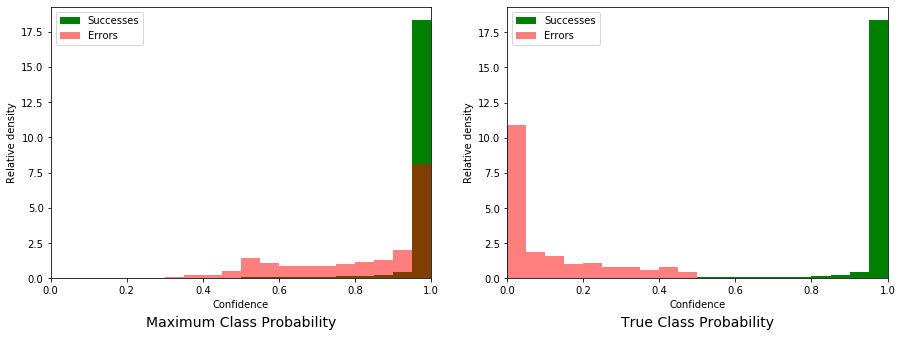

In [8]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title('Maximum Class Probability', y=-0.2, fontsize=14)
plt.hist(confidence_normal[np.where(accurate_normal==1)], 
         bins=np.linspace(0, 1,num=21), density=True, color='green',label='Successes')
plt.hist(confidence_normal[np.where(accurate_normal==0)], 
         bins=np.linspace(0, 1,num=21), density=True, alpha=0.5, color='red',label='Errors')
plt.xlabel('Confidence')
plt.ylabel('Relative density')
plt.xlim(left=0, right=1)
plt.legend()
plt.subplot(122)
plt.title('True Class Probability', y=-0.2, fontsize=14)
plt.hist(confidence_gt[np.where(accurate_gt==1)], 
         bins=np.linspace(0, 1,num=21), density=True, color='green',label='Successes')
plt.hist(confidence_gt[np.where(accurate_gt==0)], 
         bins=np.linspace(0, 1,num=21), density=True, alpha=0.5, color='red',label='Errors')
plt.xlabel('Confidence')
plt.ylabel('Relative density')
plt.xlim(left=0, right=1)
plt.legend()
plt.show()